In [19]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import plotly.graph_objects as go
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

import tools as t

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Table of Contents

- [Génération des données](##Génération-des-données)
- [Calibration SVI](#SVI-Calibration)
- [Interpolation des paramètres](#Interpolation-des-paramètres-SVI)
- [Visualisation](#Visualisation)
- [Dupire](#Dupire)


## Génération des données

In [20]:
df = t.synthetic_options_dataset(100, 20, 100, 0.01, 0.15, 0.0, 0.3, 10)
df.iloc[200,:]

OptionType          call
Strike              80.0
Maturity        1.459596
Volatility      0.166956
Spot                 100
RiskFreeRate        0.01
Name: 200, dtype: object

In [21]:
df = t.synthetic_options_dataset(100, 20, 100, 0.01, 0.15, 0.001, 0.3, 10)

In [22]:
call_test = t.CallOption(S=100, K=df.iloc[0,1], T=df.iloc[0,2], r=0.01)

call_test_price = call_test.price(sigma = df.iloc[0,3])

In [23]:
call_test_price

20.499224634307552

## SVI Calibration

#### Généralisation pour toutes les maturités du dataset

On détermine pour chaque maturité T du dataset les paramètres a, b, rho, m et sigma qui permettent de modéliser le smile

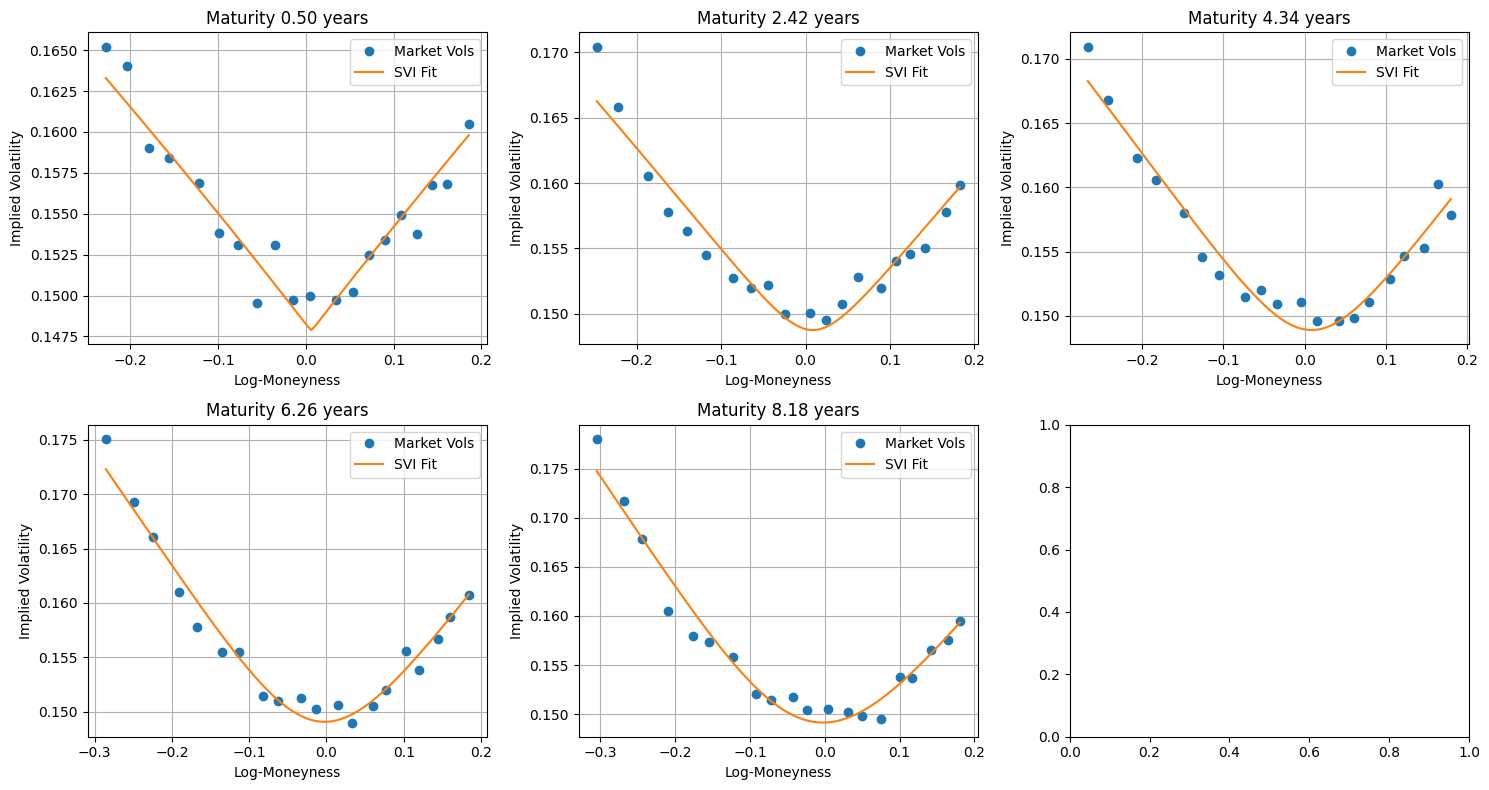

In [24]:
svi_params_by_maturity = {}
maturities = sorted(df['Maturity'].unique())
maturities_to_plot = maturities[::len(maturities)//5] #échantillon de maturités pour visualiser le résultat du calibrage pour différentes maturités


import math
n_plots = len(maturities_to_plot)
cols = 3
rows = math.ceil(n_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()  

for i, T in enumerate(maturities):

    df_slice = df[df['Maturity'] == T]
    
    F = df_slice['Spot'].iloc[0] * np.exp(df_slice['RiskFreeRate'].iloc[0] * T)
    
    k = np.log(df_slice['Strike'] / F)
    
    total_var_market = (df_slice['Volatility'] ** 2) * T

    init_guess = [0.01, 0.1, 0.0, 0.0, 0.1]
    bounds = [(-1, 1), (1e-5, 10), (-0.999, 0.999), (-5, 5), (1e-5, 5)]
    lam = 0.0001 #paramètre de régularisation pour la minimisation de svi_objective
    
    #minimisation avec 
    result = minimize(
        t.svi_objective,
        x0=init_guess,
        args=(k.values, total_var_market.values, lam),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 1000000, 'ftol': 1e-12, 'gtol': 1e-12, 'disp': False}
    )
    
    a, b, rho, m, sigma = result.x
    svi_params_by_maturity[T] = {'a': a, 'b': b, 'rho': rho, 'm': m, 'sigma': sigma}
    
    
    if T in maturities_to_plot:
        k_fit = np.linspace(min(k), max(k), 100)
        w_fit = t.svi_total_variance(k_fit, a, b, rho, m, sigma)
        vol_fit = np.sqrt(w_fit / T)
        
        ax = axes[maturities_to_plot.index(T)]
        ax.plot(k, np.sqrt(total_var_market / T), 'o', label='Market Vols')
        ax.plot(k_fit, vol_fit, label='SVI Fit')
        ax.set_title(f'Maturity {T:.2f} years')
        ax.set_xlabel('Log-Moneyness')
        ax.set_ylabel('Implied Volatility')
        ax.legend()
        ax.grid(True)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
%matplotlib inline
plt.show()


## Interpolation des paramètres SVI

Utilisation d'une régression polynomiale de Ridge pour interpoler les paramètres SVI pour une maturité continue

In [25]:
Ts = []
params = []

for T, param_dict in svi_params_by_maturity.items():
    Ts.append(T)
    params.append([
        param_dict['a'],
        param_dict['b'],
        param_dict['rho'],
        param_dict['m'],
        param_dict['sigma']
    ])



In [26]:


Ts = np.array(Ts)
params = np.array(params)  

sorted_indices = np.argsort(Ts)
Ts_sorted = Ts[sorted_indices]
params_sorted = params[sorted_indices]

#Paramètres de la régression polynomiale ridge
degree = 3
alpha = 0.1

models = []
for i in range(params.shape[1]):
    y = params_sorted[:, i]
    model = make_pipeline(
        PolynomialFeatures(degree),
        Ridge(alpha=alpha)
    )
    model.fit(Ts_sorted.reshape(-1,1), y)
    models.append(model)


def svi_params(T):
    T_arr = np.array(T).reshape(-1, 1)
    param_pred = np.array([model.predict(T_arr).flatten() for model in models]).T
    
    if param_pred.shape[0] == 1:
        param_pred = param_pred[0]

    if param_pred.ndim == 1:
        a, b, rho, m, sigma = param_pred
        b = max(b, 1e-4)
        sigma = max(sigma, 1e-4)
        rho = np.clip(rho, -0.999, 0.999)
        return np.array([a, b, rho, m, sigma])
    else:
        a = param_pred[:,0]
        b = np.maximum(param_pred[:,1], 1e-4)
        rho = np.clip(param_pred[:,2], -0.999, 0.999)
        m = param_pred[:,3]
        sigma = np.maximum(param_pred[:,4], 1e-4)
        return np.vstack([a,b,rho,m,sigma]).T


In [27]:

params_at_T = svi_params(1)
print("Paramètres SVI interpolés pour T=1", ":", params_at_T)

Paramètres SVI interpolés pour T=1 : [ 0.0218717   0.02079676 -0.00372741  0.00445168  0.00807509]


## Visualisation

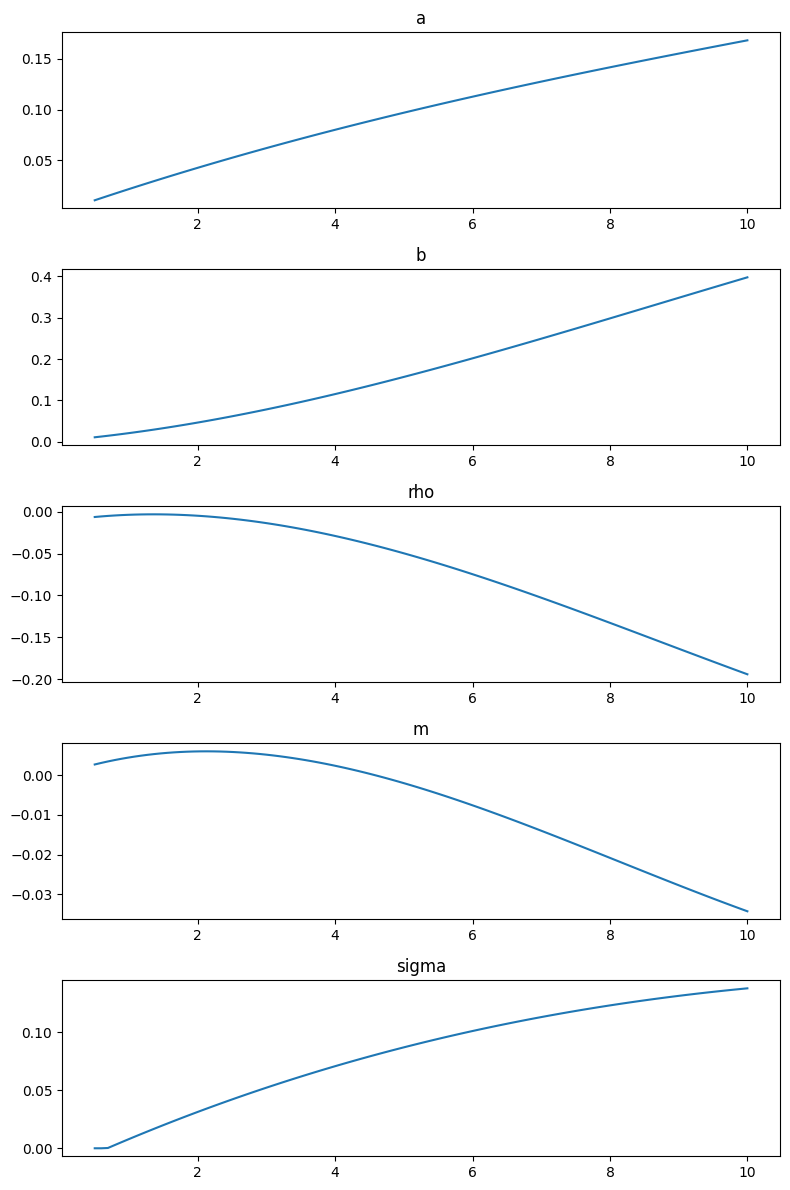

In [28]:
T_plot = np.linspace(min(Ts_sorted), max(Ts_sorted), 100)
params_plot = svi_params(T_plot)

names = ['a', 'b', 'rho', 'm', 'sigma']
fig, axs = plt.subplots(5,1, figsize=(8,12))

for i, ax in enumerate(axs):
    ax.plot(T_plot, params_plot[:,i])
    ax.set_title(names[i])
plt.tight_layout()
plt.show()


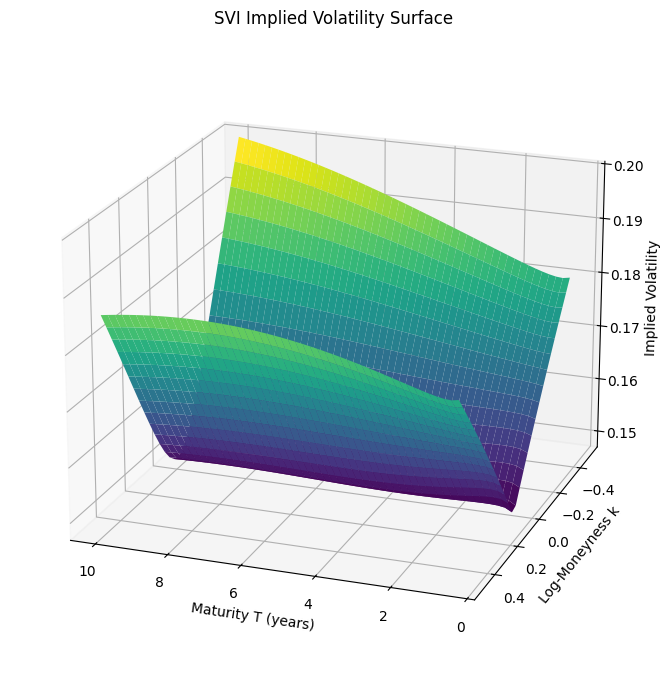

In [29]:


spot = 100 
r = 0.01   


T_grid = np.linspace(min(Ts), max(Ts), 50)   
k_grid = np.linspace(-0.5, 0.5, 30)              

T_mesh, k_mesh = np.meshgrid(T_grid, k_grid)

vol_surface = np.zeros_like(T_mesh)

for i in range(T_mesh.shape[0]):
    for j in range(T_mesh.shape[1]):
        T_val = T_mesh[i, j]
        k_val = k_mesh[i, j]
        a, b, rho, m, sigma = svi_params(T_val)  
        
        F = spot * np.exp(r * T_val)            
        K = F * np.exp(k_val)                   
        
        vol_surface[i, j] = t.svi_implied_vol(K, spot, T_val, r, a, b, rho, m, sigma)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T_mesh, k_mesh, vol_surface, cmap='viridis', edgecolor='none')
ax.set_xlabel('Maturity T (years)')
ax.set_ylabel('Log-Moneyness k')
ax.set_zlabel('Implied Volatility')
ax.set_title('SVI Implied Volatility Surface')
ax.view_init(elev=20, azim=110)  
plt.tight_layout()
plt.show()


In [30]:


for i in range(T_mesh.shape[0]):
    for j in range(T_mesh.shape[1]):
        T_val = T_mesh[i, j]
        k_val = k_mesh[i, j]
        a, b, rho, m, sigma = svi_params(T_val)  
        
        F = spot * np.exp(r * T_val)  
        K = F * np.exp(k_val)           
        
        vol_surface[i, j] = t.svi_implied_vol(K, spot, T_val, r, a, b, rho, m, sigma)

fig = go.Figure(data=[go.Surface(
    x=T_mesh,
    y=k_mesh,
    z=vol_surface,
    colorscale='Viridis'
)])

fig.update_layout(
    title='SVI Implied Volatility Surface interactive',
    scene=dict(
        xaxis_title='Maturity T (years)',
        yaxis_title='Log-Moneyness k',
        zaxis_title='Implied Volatility'
    ),
    autosize=False,
    height=600,
)

fig.show()


In [31]:
df['Fwd'] = df['Spot'] * np.exp(df['RiskFreeRate'] * df['Maturity'])
df['k'] = np.log(df['Strike'] / df['Fwd'])

fig=go.Figure()



for i in range(T_mesh.shape[0]):
    for j in range(T_mesh.shape[1]):
        T_val = T_mesh[i, j]
        k_val = k_mesh[i, j]
        a, b, rho, m, sigma = svi_params(T_val)  
        
        F = spot * np.exp(r * T_val)  
        K = F * np.exp(k_val)           
        
        vol_surface[i, j] = t.svi_implied_vol(K, spot, T_val, r, a, b, rho, m, sigma)

fig = go.Figure(data=[go.Surface(
    x=T_mesh,
    y=k_mesh,
    z=vol_surface,
    colorscale='Viridis'
)])

fig.update_layout(
    title='SVI Implied Volatility Surface interactive',
    scene=dict(
        xaxis_title='Maturity T (years)',
        yaxis_title='Log-Moneyness k',
        zaxis_title='Implied Volatility'
    ),
    autosize=False,
    height=600,
)
scatter = go.Scatter3d(
    x=df['Maturity'],
    y=df['k'],
    z=df['Volatility'],
    mode='markers',
    marker=dict(
        size=2,
        color='red'
        
    ),
    name='Market Data'
)

fig.add_trace(scatter)


## Dupire

#### Passage de la vol implicite à la vol locale

In [32]:
k_grid

array([-0.5       , -0.46551724, -0.43103448, -0.39655172, -0.36206897,
       -0.32758621, -0.29310345, -0.25862069, -0.22413793, -0.18965517,
       -0.15517241, -0.12068966, -0.0862069 , -0.05172414, -0.01724138,
        0.01724138,  0.05172414,  0.0862069 ,  0.12068966,  0.15517241,
        0.18965517,  0.22413793,  0.25862069,  0.29310345,  0.32758621,
        0.36206897,  0.39655172,  0.43103448,  0.46551724,  0.5       ])

In [33]:
dT = T_grid[1] - T_grid[0]  
dk = k_grid[1] - k_grid[0]  


dvol_dT = np.gradient(vol_surface, dT, axis=1) 
dvol_dk = np.gradient(vol_surface, dk, axis=0)
d2vol_dk2 = np.gradient(dvol_dk, dk, axis=0) 


In [34]:



T_mat = T_grid[np.newaxis, :]    
k_mat = k_grid[:, np.newaxis]    

num = (
    vol_surface**2 +
    2 * T_mat * vol_surface * dvol_dT +
    2 * r * T_mat * k_mat * vol_surface * dvol_dk
)

den = (
    (1 + (k_mat / vol_surface) * dvol_dk)**2 +
    T_mat * (d2vol_dk2 + (dvol_dk**2) / vol_surface)
)

local_var = num / den


In [35]:
local_var = np.maximum(local_var, 0)  
local_vol = np.sqrt(local_var)


In [36]:

T_mesh, k_mesh = np.meshgrid(T_grid, k_grid)

fig = go.Figure(data=[go.Surface(
    x=T_mesh,
    y=k_mesh,
    z=local_vol,
    colorscale='Viridis',
    colorbar=dict(title='Local Volatility')
)])

fig.update_layout(
    title='Dupire Local Volatility Surface',
    scene=dict(
        xaxis_title='Maturity T (years)',
        yaxis_title='Log-Moneyness k',
        zaxis_title='Local Volatility σ_loc'
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()
